In [1]:
pip install opencv-python numpy csv

ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


In [2]:
!pip install opencv-contrib-python

In [3]:
import cv2
print(cv2.__version__)
print(dir(cv2.face))

4.11.0
['BIF', 'BIF_create', 'BasicFaceRecognizer', 'EigenFaceRecognizer', 'EigenFaceRecognizer_create', 'FaceRecognizer', 'Facemark', 'FacemarkAAM', 'FacemarkKazemi', 'FacemarkLBF', 'FacemarkTrain', 'FisherFaceRecognizer', 'FisherFaceRecognizer_create', 'LBPHFaceRecognizer', 'LBPHFaceRecognizer_create', 'MACE', 'MACE_create', 'MACE_load', 'PredictCollector', 'StandardCollector', 'StandardCollector_create', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_native', 'createFacemarkAAM', 'createFacemarkKazemi', 'createFacemarkLBF', 'drawFacemarks', 'getFacesHAAR', 'loadDatasetList', 'loadFacePoints', 'loadTrainingData']


In [4]:
!pip install dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2025-02-26 13:52:08--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-02-26 13:52:09--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  33.3MB/s    in 1.8s    

2025-02-26 13:52:11 (33.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]




1. Register Face
2. Log In
3. Log Off
4. Exit
Select option: 1
Enter your name: Hassan
Look at the camera and blink normally...


<IPython.core.display.Javascript object>

Model updated with new registrations
Hassan registered successfully!

1. Register Face
2. Log In
3. Log Off
4. Exit
Select option: 2
Look at the camera and blink normally for verification...


<IPython.core.display.Javascript object>

Liveness check failed - no blink detected

1. Register Face
2. Log In
3. Log Off
4. Exit
Select option: 2
Look at the camera and blink normally for verification...


<IPython.core.display.Javascript object>

Attendance logged: Hassan Log In at 18:54:26


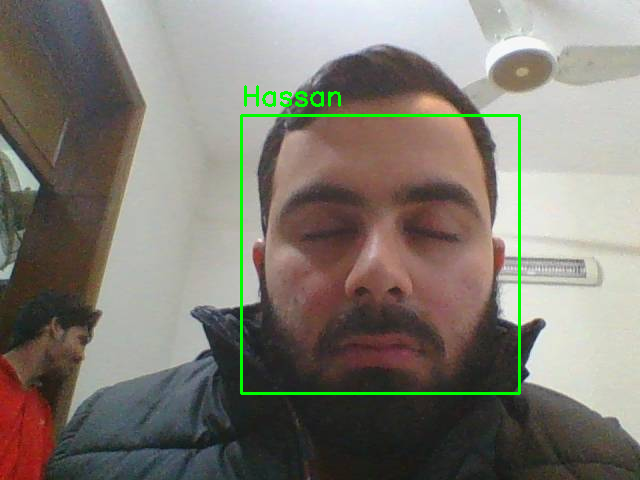


1. Register Face
2. Log In
3. Log Off
4. Exit
Select option: 2
Look at the camera and blink normally for verification...


<IPython.core.display.Javascript object>

Liveness check failed - no blink detected

1. Register Face
2. Log In
3. Log Off
4. Exit
Select option: 2
Look at the camera and blink normally for verification...


<IPython.core.display.Javascript object>

Hassan already logged in today!


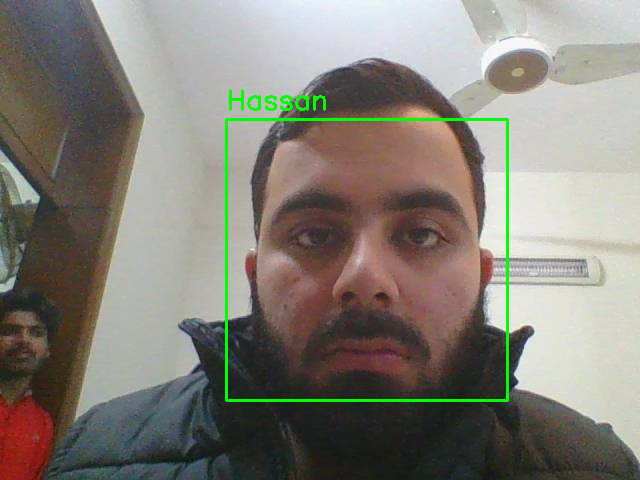


1. Register Face
2. Log In
3. Log Off
4. Exit
Select option: 3


<IPython.core.display.Javascript object>

Attendance logged: Hassan Log Off at 18:55:34


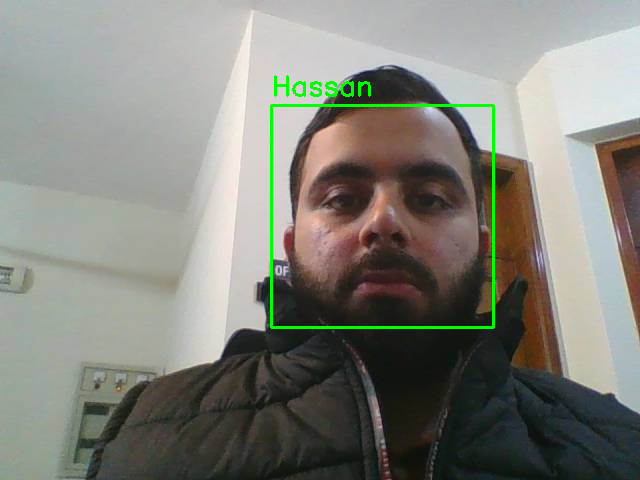


1. Register Face
2. Log In
3. Log Off
4. Exit
Select option: 4


In [6]:
import cv2
import numpy as np
import os
import csv
from datetime import datetime
import pytz
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode
import dlib
from scipy.spatial import distance


# ----------
# Webcam Setup (Colab-specific)
# ----------
def take_photo_burst(num_frames=3, delay=500, quality=0.7):
    js = Javascript('''
    async function takeBurst(num, delay, quality) {
        const div = document.createElement('div');
        const btn = document.createElement('button');
        btn.textContent = 'Capture';
        div.appendChild(btn);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight);
        await new Promise(resolve => btn.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        const ctx = canvas.getContext('2d');

        const frames = [];
        for(let i=0; i<num; i++) {
            ctx.drawImage(video, 0, 0);
            frames.push(canvas.toDataURL('image/jpeg', quality));
            await new Promise(resolve => setTimeout(resolve, delay));
        }

        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return frames;
    }
    ''')

    display(js)
    data = eval_js(f'takeBurst({num_frames}, {delay}, {quality})')
    return [b64decode(f.split(',')[1]) for f in data]

# ----------
# Liveness Detection
# ----------
class BlinkDetector:
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        self.EYE_AR_THRESH = 0.22
        self.EYE_AR_CONSEC_FRAMES = 1

    @staticmethod
    def eye_aspect_ratio(eye):
        A = distance.euclidean(eye[1], eye[5])
        B = distance.euclidean(eye[2], eye[4])
        C = distance.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def detect(self, frames):
        max_blinks = 0
        current_blinks = 0

        for frame_data in frames:
            img_np = np.frombuffer(frame_data, np.uint8)
            frame = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
            if frame is None: continue

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = self.detector(gray, 0)

            for face in faces:
                shape = self.predictor(gray, face)
                shape = np.array([(shape.part(i).x, shape.part(i).y) for i in range(68)])

                try:
                    left_eye = shape[42:48]
                    right_eye = shape[36:42]
                    ear = (self.eye_aspect_ratio(left_eye) + self.eye_aspect_ratio(right_eye)) / 2.0

                    if ear < self.EYE_AR_THRESH:
                        current_blinks += 1
                        max_blinks = max(max_blinks, current_blinks)
                    else:
                        current_blinks = 0

                except Exception as e:
                    print(f"Eye detection error: {str(e)}")

        return max_blinks >= self.EYE_AR_CONSEC_FRAMES

# ----------
# Face Recognition System
# ----------
class AttendanceSystem:
    def __init__(self):
        self.face_detector = cv2.CascadeClassifier(
            cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        )
        self.face_recognizer = cv2.face.LBPHFaceRecognizer_create()
        self.dataset_dir = "dataset"
        self.registered_names = []
        self.blink_detector = BlinkDetector()

        os.makedirs(self.dataset_dir, exist_ok=True)
        if os.path.exists("registered_names.npy"):
            self.registered_names = np.load("registered_names.npy", allow_pickle=True).tolist()

    def register_face(self):
        name = input("Enter your name: ").strip()
        if name in self.registered_names:
            print(f"{name} already registered!")
            return

        print("Look at the camera and blink normally...")
        frames = take_photo_burst(num_frames=5, delay=500)
        if len(frames) < 5:
            print("Registration failed - could not capture enough frames")
            return

        face_samples = []
        for i, frame_data in enumerate(frames):
            img_np = np.frombuffer(frame_data, np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            faces = self.face_detector.detectMultiScale(gray, 1.1, 5)
            if len(faces) == 0:
                print(f"Frame {i+1}: No face detected")
                continue

            (x,y,w,h) = faces[0]
            face_roi = gray[y:y+h, x:x+w]
            face_samples.append(face_roi)

            cv2.imwrite(f"{self.dataset_dir}/{name}_{i}.jpg", face_roi)

        if len(face_samples) < 3:
            print("Registration failed - insufficient valid samples")
            return

        self.registered_names.append(name)
        np.save("registered_names.npy", self.registered_names)
        self.train_model()
        print(f"{name} registered successfully!")

    def train_model(self):
        faces, labels = [], []
        for label, name in enumerate(self.registered_names):
            for img_file in os.listdir(self.dataset_dir):
                if img_file.startswith(name):
                    img_path = os.path.join(self.dataset_dir, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        faces.append(img)
                        labels.append(label)

        if len(faces) > 0:
            self.face_recognizer.train(faces, np.array(labels))
            self.face_recognizer.save("trained_model.yml")
            print("Model updated with new registrations")

    def recognize_face(self):
        if not os.path.exists("trained_model.yml"):
            print("No trained model found!")
            return

        self.face_recognizer.read("trained_model.yml")
        print("Look at the camera and blink normally for verification...")
        frames = take_photo_burst()
        if not frames:
            print("No frames captured")
            return

        if not self.blink_detector.detect(frames):
            print("Liveness check failed - no blink detected")
            return

        img_np = np.frombuffer(frames[0], np.uint8)
        img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector.detectMultiScale(gray, 1.2, 7)

        for (x,y,w,h) in faces:
            face_roi = gray[y:y+h, x:x+w]
            label, confidence = self.face_recognizer.predict(face_roi)

            if confidence < 60:
                name = self.registered_names[label]
                self.log_attendance(name, "Log In")
                cv2.putText(img, name, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
            else:
                cv2.putText(img, "Unknown", (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

        cv2_imshow(img)

    def log_off(self):
        frames = take_photo_burst()
        if not frames:
            print("No frames captured")
            return

        # if not self.blink_detector.detect(frames):
        #     print("Liveness check failed - no blink detected")
        #     return

        img_np = np.frombuffer(frames[0], np.uint8)
        img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector.detectMultiScale(gray, 1.1, 5)

        if not os.path.exists("trained_model.yml"):
            print("No trained model found. Please register a face first.")
            return

        self.face_recognizer.read("trained_model.yml")

        for (x,y,w,h) in faces:
            face_roi = gray[y:y+h, x:x+w]
            label, confidence = self.face_recognizer.predict(face_roi)

            if confidence < 60:
                name = self.registered_names[label]
                self.log_attendance(name, "Log Off")
                cv2.putText(img, name, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
            else:
                cv2.putText(img, "Unknown", (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

        cv2_imshow(img)

    def log_attendance(self, name, action):
        now = datetime.now(pytz.timezone('Asia/Karachi'))
        date_str = now.strftime("%Y-%m-%d")
        time_str = now.strftime("%H:%M:%S")

        #check existing attendance
        entries = []
        if os.path.exists("attendance.csv"):
            with open("attendance.csv", "r") as f:
                reader = csv.reader(f)
                entries = list(reader)

        #check for duplicates
        last_action = None
        for entry in reversed(entries):
            if entry[0] == name and entry[1] == date_str:
                last_action = entry[3]
                break

        if action == "Log In" and last_action == "Log In":
            print(f"{name} already logged in today!")
            return
        if action == "Log Off" and (last_action != "Log In" or last_action == "Log Off"):
            print(f"{name} must log in before logging out!")
            return

        #log new entry
        with open("attendance.csv", "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([name, date_str, time_str, action])
        print(f"Attendance logged: {name} {action} at {time_str}")

# ----------
# Main Program
# ----------
if __name__ == "__main__":
    system = AttendanceSystem()

    while True:
        print("\n1. Register Face\n2. Log In\n3. Log Off\n4. Exit")
        choice = input("Select option: ").strip()

        if choice == '1':
            system.register_face()
        elif choice == '2':
            system.recognize_face()
        elif choice == '3':
            system.log_off()
        elif choice == '4':
            break
        else:
            print("Invalid choice!")

In [7]:
from flask import Flask, request, jsonify
import cv2
import numpy as np
import os
import csv
from datetime import datetime
import pytz
from base64 import b64decode
import dlib
from scipy.spatial import distance

app = Flask(__name__)
print("hello world")
# ----------
# Liveness Detection
# ----------
class BlinkDetector:
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        self.EYE_AR_THRESH = 0.22
        self.EYE_AR_CONSEC_FRAMES = 1

    @staticmethod
    def eye_aspect_ratio(eye):
        A = distance.euclidean(eye[1], eye[5])
        B = distance.euclidean(eye[2], eye[4])
        C = distance.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def detect(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.detector(gray, 0)

        for face in faces:
            shape = self.predictor(gray, face)
            shape = np.array([(shape.part(i).x, shape.part(i).y) for i in range(68)])

            left_eye = shape[42:48]
            right_eye = shape[36:42]
            ear = (self.eye_aspect_ratio(left_eye) + self.eye_aspect_ratio(right_eye)) / 2.0

            if ear < self.EYE_AR_THRESH:
                return True
        return False

# ----------
# Face Recognition System
# ----------
class AttendanceSystem:
    def __init__(self):
        self.face_detector = cv2.CascadeClassifier(
            cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        )
        self.face_recognizer = cv2.face.LBPHFaceRecognizer_create()
        self.dataset_dir = "dataset"
        self.registered_names = []
        self.blink_detector = BlinkDetector()

        os.makedirs(self.dataset_dir, exist_ok=True)
        self.load_registered_names()

    def load_registered_names(self):
        if os.path.exists("registered_names.npy"):
            self.registered_names = np.load("registered_names.npy", allow_pickle=True).tolist()

    def register_face(self, name, images):
        try:
            face_samples = []
            for img_base64 in images:
                img_data = base64.b64decode(img_base64)
                img_np = np.frombuffer(img_data, np.uint8)
                img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)

                if not self.blink_detector.detect(img):
                    return {"error": "Liveness check failed"}

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = self.face_detector.detectMultiScale(gray, 1.1, 5)

                if len(faces) == 0:
                    return {"error": "No face detected"}

                (x,y,w,h) = faces[0]
                face_roi = gray[y:y+h, x:x+w]
                face_samples.append(face_roi)
                cv2.imwrite(f"{self.dataset_dir}/{name}_{len(face_samples)}.jpg", face_roi)

            if len(face_samples) < 3:
                return {"error": "Insufficient valid samples"}

            if name not in self.registered_names:
                self.registered_names.append(name)
                np.save("registered_names.npy", self.registered_names)
                self.train_model()

            return {"message": f"{name} registered successfully"}

        except Exception as e:
            return {"error": str(e)}

    def train_model(self):
        faces, labels = [], []
        for label, name in enumerate(self.registered_names):
            for img_file in os.listdir(self.dataset_dir):
                if img_file.startswith(name):
                    img_path = os.path.join(self.dataset_dir, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        faces.append(img)
                        labels.append(label)

        if faces:
            self.face_recognizer.train(faces, np.array(labels))
            self.face_recognizer.save("trained_model.yml")

    def recognize_face(self, image_base64):
        try:
            if not os.path.exists("trained_model.yml"):
                return {"error": "No trained model found"}

            img_data = base64.b64decode(image_base64)
            img_np = np.frombuffer(img_data, np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)

            if not self.blink_detector.detect(img):
                return {"error": "Liveness check failed"}

            self.face_recognizer.read("trained_model.yml")
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = self.face_detector.detectMultiScale(gray, 1.2, 7)

            for (x,y,w,h) in faces:
                face_roi = gray[y:y+h, x:x+w]
                label, confidence = self.face_recognizer.predict(face_roi)

                if confidence < 60:
                    name = self.registered_names[label]
                    self.log_attendance(name, "Log In")
                    return {"message": f"{name} logged in successfully"}

            return {"error": "Unknown face"}

        except Exception as e:
            return {"error": str(e)}

    def log_attendance(self, name, action):
        now = datetime.now(pytz.timezone('Asia/Karachi'))
        date_str = now.strftime("%Y-%m-%d")
        time_str = now.strftime("%H:%M:%S")

        with open("attendance.csv", "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([name, date_str, time_str, action])

attendance_system = AttendanceSystem()

# ----------
# API Endpoints
# ----------
@app.route('/register', methods=['POST'])
def register():
    data = request.json
    name = data.get('name')
    images = data.get('images', [])

    if not name or len(images) < 3:
        return jsonify({"error": "Name and at least 3 images required"}), 400

    result = attendance_system.register_face(name, images)
    return jsonify(result)

@app.route('/recognize', methods=['POST'])
def recognize():
    data = request.json
    image = data.get('image')

    if not image:
        return jsonify({"error": "Image required"}), 400

    result = attendance_system.recognize_face(image)
    return jsonify(result)

@app.route('/attendance', methods=['GET'])
def get_attendance():
    if not os.path.exists("attendance.csv"):
        return jsonify({"error": "No attendance records found"}), 404

    records = []
    with open("attendance.csv", "r") as f:
        reader = csv.reader(f)
        for row in reader:
            records.append({
                "name": row[0],
                "date": row[1],
                "time": row[2],
                "action": row[3]
            })

    return jsonify({"attendance": records})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)

hello world
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
